<a href="https://colab.research.google.com/github/Gayeon6423/Analysis-of-Resource-Allocation-Efficiency-in-Manufacturing-Industry-Linked-to-Greenhouse-Gas-Data/blob/main/Modeling_total.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Load Library & Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1-1. Load Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

### 1-2. Data Load

In [ ]:
file_path = '/content/drive/MyDrive/SSK_한국연구재단(2023)/(소논문)온실가스 데이터와 연계한 지역간 제조업 자원배분 효율성 분석/data/'
city_data = pd.read_csv(file_path + 'manu_city_data.csv')
seoul_gas = pd.read_csv(file_path + '온실가스 데이터/seoul.csv')
busan_gas = pd.read_csv(file_path + '온실가스 데이터/Busan.csv')
gwangju_gas = pd.read_csv(file_path + '온실가스 데이터/Gwangju.csv')
daegu_gas = pd.read_csv(file_path + '온실가스 데이터/Daegu.csv')
daejeon_gas = pd.read_csv(file_path + '온실가스 데이터/daejeon.csv')
incheon_gas = pd.read_csv(file_path + '온실가스 데이터/Incheon.csv')
ulsan_gas = pd.read_csv(file_path + '온실가스 데이터/Ulsan.csv')

In [ ]:
city_mapping = {11:'서울',
                21:'부산',
                22:'대구',
                23:'인천',
                24:'광주',
                25:'대전',
                26:'울산'}
city_data['c_city'].replace(city_mapping, inplace=True)

### 1-3. data 명세

- Product function : Y = A * L^alpha * K^beta * E^(1-alpha-beta)
- Labor : pay1 + pay3
- Kapital : (fasset_b + fasset_e) / 2  
- Eenergy : cost_fuel + cost_elec
- Y(productivity) : vadd

In [ ]:
city_data = city_data[['id','c1','c2','c3','year','c_city','pay1','pay3','fasset_b','fasset_e','cost_fuel','cost_elec','vadd']]

## 2. Data Preprocessing

### 2-1. 결측치 제거

In [ ]:
# 결측치가 있는 행 제거
city_data = city_data.dropna()
# 결측치 확인
city_data.isnull().sum()

id           0
c1           0
c2           0
c3           0
year         0
c_city       0
pay1         0
pay3         0
fasset_b     0
fasset_e     0
cost_fuel    0
cost_elec    0
vadd         0
dtype: int64

### 2-2. 이상치 제거

In [ ]:
# 실질 생산성이 0인 기업 삭제
city_data = city_data[city_data['vadd'] != 0]

### 2-3. 변수 생성

In [ ]:
city_data['Labor'] = city_data['pay1'] + city_data['pay3']
city_data['Kapital'] = (city_data['fasset_b'] + city_data['fasset_b']) / 2
city_data['Energy'] = city_data['cost_fuel'] + city_data['cost_elec']

### 2-4. 실질 변수 변환
- 제조업 생산자물가지수 : 119.84
- 실질변수 = 명목변수 / 제조업 생산자물가지수

In [ ]:
price_index = 119.84
city_data['Labor_real'] = city_data['Labor'] / price_index
city_data['Kapital_real'] = city_data['Kapital'] / price_index
city_data['Energy_real'] = city_data['Energy'] / price_index
city_data['productivity_real'] = city_data['vadd'] / price_index

### 2-5. 각 변수 값 / 2자릿수 기준 산업평균 값

In [ ]:
# 산업코드(c2,c3) 분류의 가중평균 값(가중치 : 부가가치)
labor_weight_mean = city_data.groupby(['c2','c3']).apply(lambda x: (x['Labor_real'] * x['vadd']).sum() / x['vadd'].sum())
kapital_weight_mean = city_data.groupby(['c2','c3']).apply(lambda x: (x['Kapital_real'] * x['vadd']).sum() / x['vadd'].sum())
energy_weight_mean = city_data.groupby(['c2','c3']).apply(lambda x: (x['Energy_real'] * x['vadd']).sum() / x['vadd'].sum())
productivity_weight_mean = city_data.groupby(['c2','c3']).apply(lambda x: (x['productivity_real'] * x['vadd']).sum() / x['vadd'].sum())

# 가중평균을 데이터프레임으로 변환
labor_weight_mean_df = labor_weight_mean.reset_index(name='labor_weight_mean')
kapital_weight_mean_df = kapital_weight_mean.reset_index(name='kapital_weight_mean')
energy_weight_mean_df = energy_weight_mean.reset_index(name='energy_weight_mean')
productivity_weight_mean_df = productivity_weight_mean.reset_index(name='productivity_weight_mean')

# 기존 데이터프레임에 'c2'와 'c3' 값을 기준으로 가중평균 값 병합
city_data =  city_data.merge(labor_weight_mean_df, on=['c2', 'c3'])
city_data =  city_data.merge(kapital_weight_mean_df, on=['c2', 'c3'])
city_data =  city_data.merge(energy_weight_mean_df, on=['c2', 'c3'])
city_data =  city_data.merge(productivity_weight_mean_df, on=['c2', 'c3'])

# 해당기업 값 / 산업코드 기준 가중평균 값
city_data['Labor_real_mean'] = city_data['Labor_real'] / city_data['labor_weight_mean']
city_data['Kapital_real_mean'] = city_data['Kapital_real'] / city_data['kapital_weight_mean']
city_data['Energy_real_mean'] = city_data['Energy_real'] / city_data['energy_weight_mean']
city_data['productivity_real_mean'] = city_data['productivity_real'] / city_data['productivity_weight_mean']

### 2-4. 한계생산요소 변환

In [ ]:
city_data['Margin_Labor'] = city_data['productivity_real_mean'] / city_data['Labor_real_mean']
city_data['Margin_Labor'].replace([np.inf, -np.inf], city_data['Margin_Labor'].median(), inplace=True)

city_data['Margin_Kapital'] = city_data['productivity_real_mean'] / city_data['Kapital_real_mean']
city_data['Margin_Kapital'].replace([np.inf, -np.inf], city_data['Margin_Kapital'].median(), inplace=True)

city_data['Margin_Energy'] = city_data['productivity_real_mean'] / city_data['Energy_real_mean']
city_data['Margin_Energy'].replace([np.inf, -np.inf], city_data['Margin_Energy'].median(), inplace=True)

city_data.describe()

,id,c2,c3,year,pay1,pay3,fasset_b,fasset_e,cost_fuel,cost_elec,...,kapital_weight_mean,energy_weight_mean,productivity_weight_mean,Labor_real_mean,Kapital_real_mean,Energy_real_mean,productivity_real_mean,Margin_Labor,Margin_Kapital,Margin_Energy
count,585466.000000,585466.000000,585466.000000,585466.000000,5.854660e+05,585466.000000,5.854660e+05,5.854660e+05,5.854660e+05,585466.000000,...,585466.000000,585466.000000,585466.000000,585466.000000,585466.000000,585466.000000,585466.000000,585466.000000,585466.000000,585466.000000
mean,293941.056475,24.170686,3.011183,2005.922452,7.572635e+02,106.238572,3.141746e+03,3.077743e+03,1.069893e+02,113.988915,...,1388.854925,76.015605,1715.606372,0.113333,0.086410,0.100520,0.074523,0.603664,10.428910,3.870861
std,170879.628835,6.316889,2.908703,5.514986,1.456190e+04,2254.122854,6.319451e+04,6.209938e+04,6.084172e+03,2480.514981,...,5287.730826,273.157646,6231.875677,0.313512,0.420462,0.511046,0.262621,0.618340,95.986479,23.727713
min,1.000000,7.000000,0.000000,1999.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.966050,0.115830,3.740675,0.000000,0.000000,0.000000,-4.411167,-17.406306,-289.485995,-279.979500
25%,146450.250000,18.000000,1.000000,2002.000000,7.800000e+01,5.000000,3.400000e+01,3.600000e+01,0.000000e+00,2.000000,...,83.835407,1.291941,94.593248,0.008872,0.000972,0.001934,0.003520,0.324259,0.739066,0.426078
50%,292824.500000,25.000000,2.000000,2005.000000,1.860000e+02,17.000000,1.560000e+02,1.580000e+02,0.000000e+00,6.000000,...,235.808636,6.274312,392.931221,0.028685,0.005652,0.012931,0.012891,0.506794,1.921994,1.157504
75%,439202.750000,29.000000,4.000000,2009.000000,4.680000e+02,52.000000,9.090000e+02,9.150000e+02,2.000000e+00,23.000000,...,768.760469,40.417525,773.785944,0.092665,0.034604,0.050139,0.049328,0.731970,4.620828,2.523870
max,608695.000000,37.000000,9.000000,2019.000000,3.127699e+06,395576.000000,9.752178e+06,9.209200e+06,1.767757e+06,394481.000000,...,41355.959767,4235.460798,45322.495516,32.364967,58.888580,120.316010,20.180224,87.784563,19748.815801,10096.603774


### 2-5. log변환

In [ ]:
# 마이너스 무한대 방지를 위해서 +0.01
# city_data['productivity_real_mean_log'] = np.log(city_data['productivity_real_mean'] + 0.001)
city_data['productivity_real_mean_log'] = np.log(city_data['productivity_real_mean'] + 0.001)

city_data['Marginal_Energy_log'] = np.log(city_data['Margin_Labor'] + 0.001)
city_data['Marginal_Kapital_log'] = np.log(city_data['Margin_Kapital'] + 0.001)
city_data['Marginal_Energy_log'] = np.log(city_data['Margin_Energy'] + 0.001)

city_data['Labor_real_mean_log'] = np.log(city_data['Labor_real_mean'] + 0.001)
city_data['Kapital_real_mean_log'] = np.log(city_data['Kapital_real_mean'] + 0.001)
city_data['Energy_real_mean_log'] = np.log(city_data['Energy_real_mean'] + 0.001)
city_data = city_data.dropna()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# 행정지역 필터링
city = '서울'
city_name = 'seoul'
city_data_seoul = city_data[city_data['c_city'] == city]

city = '부산'
city_name = 'busan'
city_data_busan = city_data[city_data['c_city'] == city]

city = '광주'
city_name = 'gwangju'
city_data_gwangju = city_data[city_data['c_city'] == city]

city = '대전'
city_name = 'daejeon'
city_data_daejeon = city_data[city_data['c_city'] == city]

city = '대구'
city_name = 'daegu'
city_data_daegu = city_data[city_data['c_city'] == city]

city = '인천'
city_name = 'incheon'
city_data_incheon= city_data[city_data['c_city'] == city]

city = '울산'
city_name = 'ulsan'
city_data_ulsan= city_data[city_data['c_city'] == city]

## 3. Regression Modeling

### 3-1. Robustness Check(전체 기간, 전체 지역)

- OLS regression

In [ ]:
# 종속변수 저장
target = city_data[['productivity_real_mean_log']]

# 독립변수 저장
x_data = city_data[['Labor_real_mean_log', 'Kapital_real_mean_log', 'Energy_real_mean_log']]

# 선형회귀분석을 위한 b0항(상수항) 추가
x_data_b0 = sm.add_constant(x_data, has_constant='add')

# 회귀모델 적합
model = sm.OLS(target, x_data_b0)
fitted_model = model.fit()

# 잔차항 계산
residuals = fitted_model.resid

# y_hat계산 : y_hat = beta0*X0 + beta1*X1 + beta2*X2 + beta3*X3
params = fitted_model.params
pred = np.dot(x_data_b0, params)
pred = pd.Series(pred)

# OLS 결과 출력
print(fitted_model.summary())

                                OLS Regression Results                                
Dep. Variable:     productivity_real_mean_log   R-squared:                       0.878
Model:                                    OLS   Adj. R-squared:                  0.878
Method:                         Least Squares   F-statistic:                 1.402e+06
Date:                        Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                                06:52:27   Log-Likelihood:            -5.0003e+05
No. Observations:                      583579   AIC:                         1.000e+06
Df Residuals:                          583575   BIC:                         1.000e+06
Df Model:                                   3                                         
Covariance Type:                    nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [ ]:
def plot_residuals(pred, residuals):
    plt.figure(figsize=(10, 6))
    plt.scatter(pred, residuals)
    plt.axhline(y=0, color='red', linestyle='dashed', linewidth=2)
    plt.title(f'Residuals Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

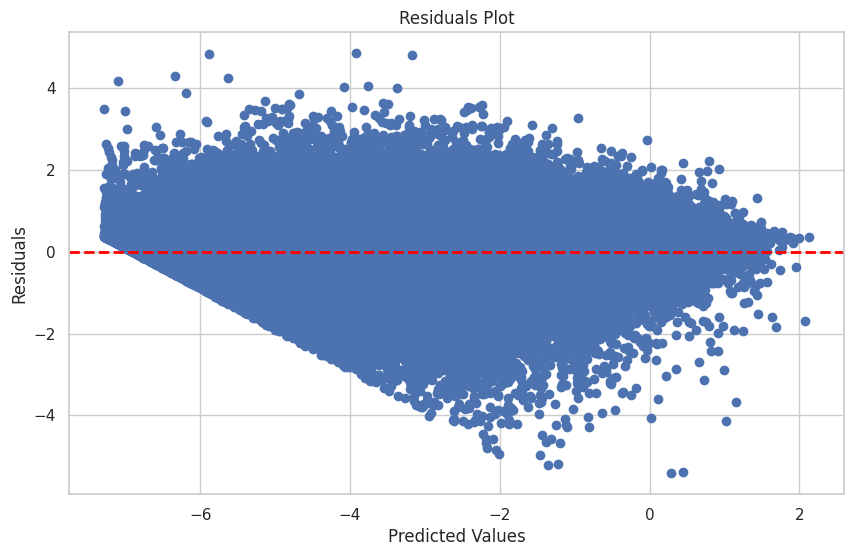

In [ ]:
# residual plot
plot_residuals(pred, residuals)

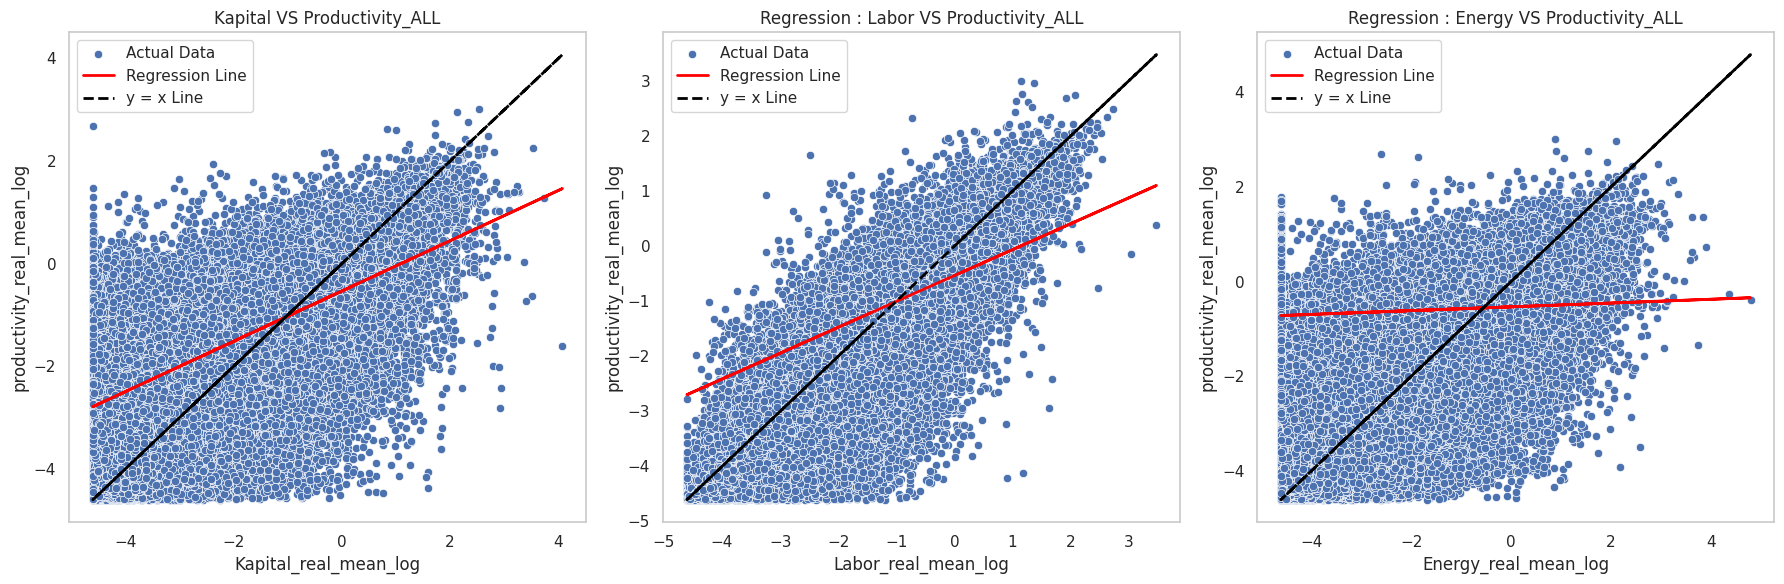

In [ ]:
# 지정된 노동 비중, 자본 비중, 에너지 비중 사용
plt.figure(figsize=(18, 6))
beta0 = fitted_model.params['const']

# 첫 번째 서브플롯: Kapital vs Productivity
plt.subplot(131)
sns.scatterplot(x='Kapital_real_mean_log', y='productivity_real_mean_log', data=city_data, label='Actual Data')
plt.plot(x_data['Kapital_real_mean_log'], beta0 + 0.49 * x_data['Kapital_real_mean_log'], color='red', linewidth=2, label='Regression Line')
plt.plot(x_data['Kapital_real_mean_log'], x_data['Kapital_real_mean_log'], color='black', linewidth=2, linestyle='dashed', label='y = x Line')
plt.title('Kapital VS Productivity_ALL')
plt.xlabel('Kapital_real_mean_log')
plt.ylabel('productivity_real_mean_log')
plt.legend()
plt.grid()

# 두 번째 서브플롯: Labor vs Productivity
plt.subplot(132)
sns.scatterplot(x='Labor_real_mean_log', y='productivity_real_mean_log', data=city_data, label='Actual Data')
plt.plot(x_data['Labor_real_mean_log'], beta0 + 0.47 * x_data['Labor_real_mean_log'], color='red', linewidth=2, label='Regression Line')
plt.plot(x_data['Labor_real_mean_log'], x_data['Labor_real_mean_log'], color='black', linewidth=2, linestyle='dashed', label='y = x Line')
plt.title('Regression : Labor VS Productivity_ALL')
plt.xlabel('Labor_real_mean_log')
plt.ylabel('productivity_real_mean_log')
plt.legend()
plt.grid()

# 세 번째 서브플롯: Energy vs Productivity
plt.subplot(133)
sns.scatterplot(x='Energy_real_mean_log', y='productivity_real_mean_log', data=city_data, label='Actual Data')
plt.plot(x_data['Energy_real_mean_log'], beta0 + 0.04 * x_data['Energy_real_mean_log'], color='red', linewidth=2, label='Regression Line')
plt.plot(x_data['Energy_real_mean_log'], x_data['Energy_real_mean_log'], color='black', linewidth=2, linestyle='dashed', label='y = x Line')
plt.title('Regression : Energy VS Productivity_ALL')
plt.xlabel('Energy_real_mean_log')
plt.ylabel('productivity_real_mean_log')
plt.legend()
plt.grid()

# 서브플롯 간 간격 조정 및 그래프 표시
plt.tight_layout()
plt.show()

### 3-2. 행정구역별 연도별 회귀분석 및 산포도



```
# 연도별로 회귀분석을 수행하는 함수 정의
def perform_regression(year, city_data):
    # 종속변수 저장
    target = city_data[['productivity_real_mean_log']]
    # 독립변수 저장
    x_data = city_data[['Marginal_Energy_log']]
    # 선형회귀분석을 위한 b0항(상수항) 추가
    x_data_b0 = sm.add_constant(x_data, has_constant='add')
    # 회귀모델 적합
    model = sm.OLS(target, x_data_b0)
    fitted_model = model.fit()
    params = fitted_model.params
    # y_hat 계산
    pred = np.dot(x_data_b0, params)
    pred = pd.Series(pred)
    # OLS 결과 출력
    print(f"Regression Results for {year}:")
    print(fitted_model.summary())
    print("\n")

# 연도별로 산점도와 회귀선 시각화하는 함수 정의
def plot_scatter_and_regression(year, city_data, var, ax):
    sns.set(style="whitegrid")

    # 서브플롯에서 회귀선을 빨간색 점선으로 설정
    sns.regplot(x=var, y='productivity_real_mean_log', data=city_data,
                line_kws={'color': 'red', 'linestyle': '--'}, ax=ax)

    # (0, 0)을 지나는 검은색 점선 추가
    ax.plot([city_data[var].min(), city_data[var].max()],
             [city_data[var].min(), city_data[var].max()],
             linestyle='--', color='black', linewidth=2)

    ax.set_title(f'{city_name}_{year}')
    ax.grid(True)

# 연도
years = [1999, 2009, 2019]
var = 'Marginal_Energy_log'
```



In [ ]:
# 연도별로 회귀분석을 수행하는 함수 정의
def perform_regression(year, city_data):
    # 종속변수 저장
    target = city_data[['productivity_real_mean_log']]
    # 독립변수 저장
    x_data = city_data[['Marginal_Energy_log']]
    # 선형회귀분석을 위한 b0항(상수항) 추가
    x_data_b0 = sm.add_constant(x_data, has_constant='add')
    # 회귀모델 적합
    model = sm.OLS(target, x_data_b0)
    fitted_model = model.fit()
    params = fitted_model.params
    # y_hat 계산
    pred = np.dot(x_data_b0, params)
    pred = pd.Series(pred)
    # OLS 결과 출력
    print(f"Regression Results for {year}:")
    print(fitted_model.summary())
    print("\n")

# 연도별로 산점도와 회귀선 시각화하는 함수 정의
def plot_scatter_and_regression(year, city_data, var, ax):
    sns.set(style="whitegrid")

    # 서브플롯에서 회귀선을 빨간색 점선으로 설정
    sns.regplot(x=var, y='productivity_real_mean_log', data=city_data,
                line_kws={'color': 'red', 'linestyle': '--'}, ax=ax)

    ax.set_title(f'{city_name}_{year}')
    ax.grid(True)
    ax.set_ylim(-8, 4)  # y축 범위 설정
    ax.set_xlabel('Marginal_Real_Energy_Mean_log')  # x축 이름 설정
    ax.set_ylabel('Real_Productivity_Mean_log')  # y축 이름 설정

# 연도
years = [1999, 2009, 2019]
var = 'Marginal_Energy_log'

- 행정구역 : 서울

In [ ]:
# 행정지역 필터링
city = '서울'
city_name = 'seoul'
city_data_seoul = city_data[city_data['c_city'] == city]

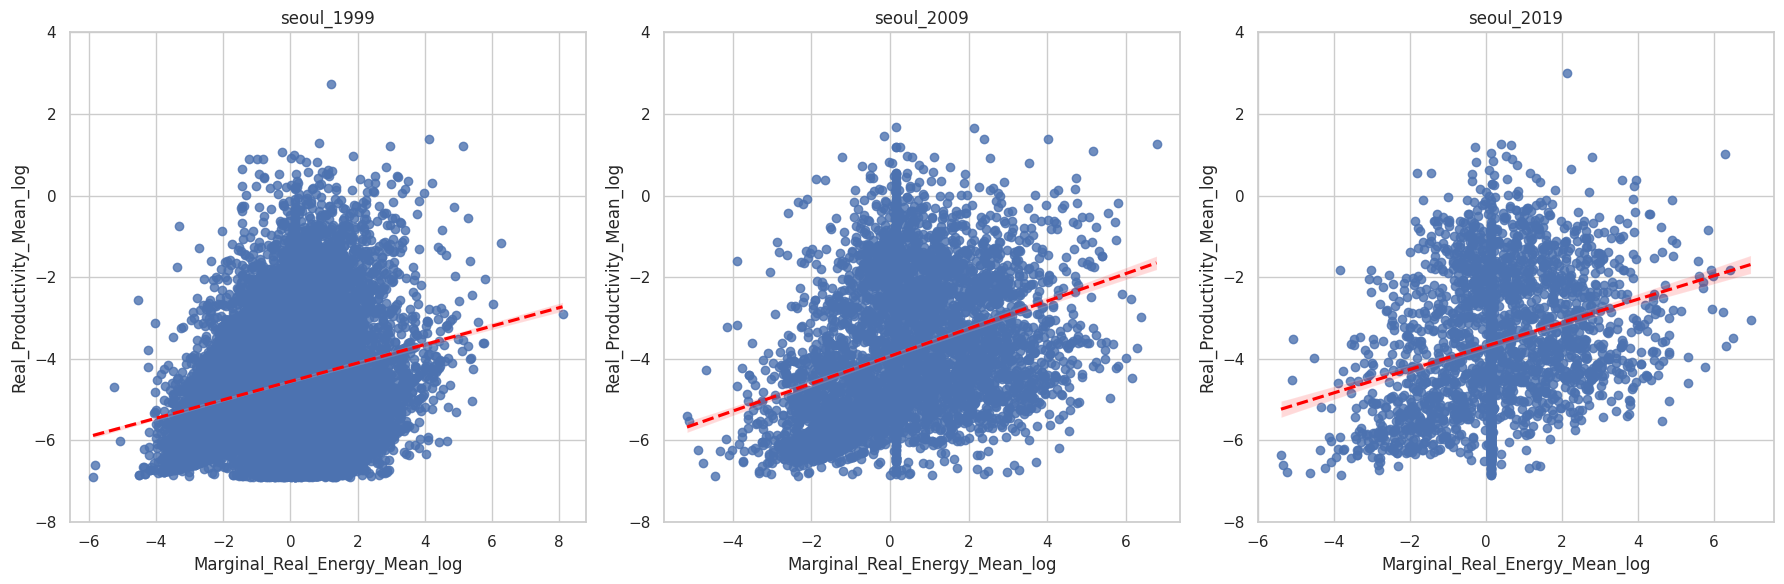

In [ ]:
# 1행 3열의 서브플롯을 생성
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, year in enumerate(years):
    city_data_year = city_data_seoul[city_data_seoul['year'] == year]
    plot_scatter_and_regression(year, city_data_year, var, ax=axes[i])

plt.tight_layout()
plt.show()

- 행정구역 : 부산

In [ ]:
# 행정지역 필터링
city = '부산'
city_name = 'busan'
city_data_busan = city_data[city_data['c_city'] == city]

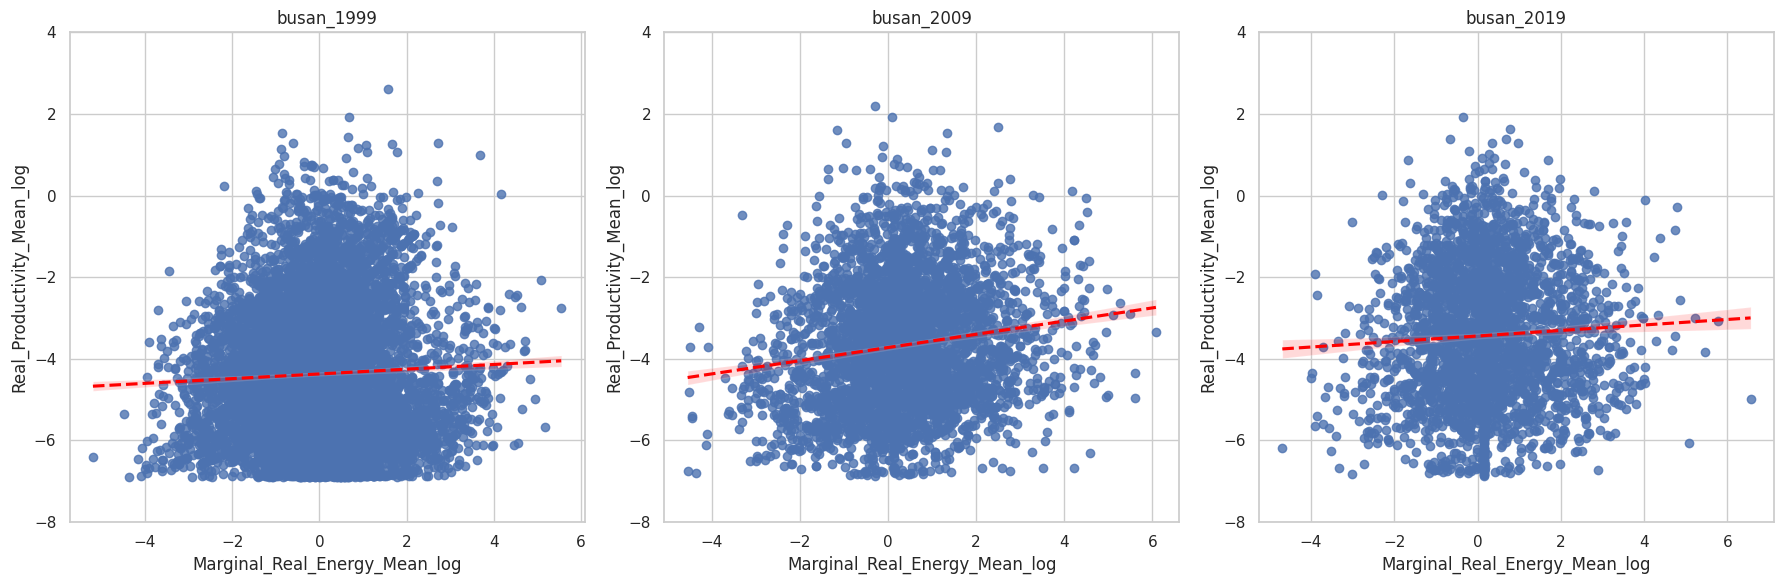

In [ ]:
# 1행 3열의 서브플롯을 생성
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, year in enumerate(years):
    city_data_year = city_data_busan[city_data_busan['year'] == year]
    plot_scatter_and_regression(year, city_data_year, var, ax=axes[i])

plt.tight_layout()
plt.show()

- 행정구역 : 광주

In [ ]:
# 행정지역 필터링
city = '광주'
city_name = 'gwangju'
city_data_gwangju = city_data[city_data['c_city'] == city]

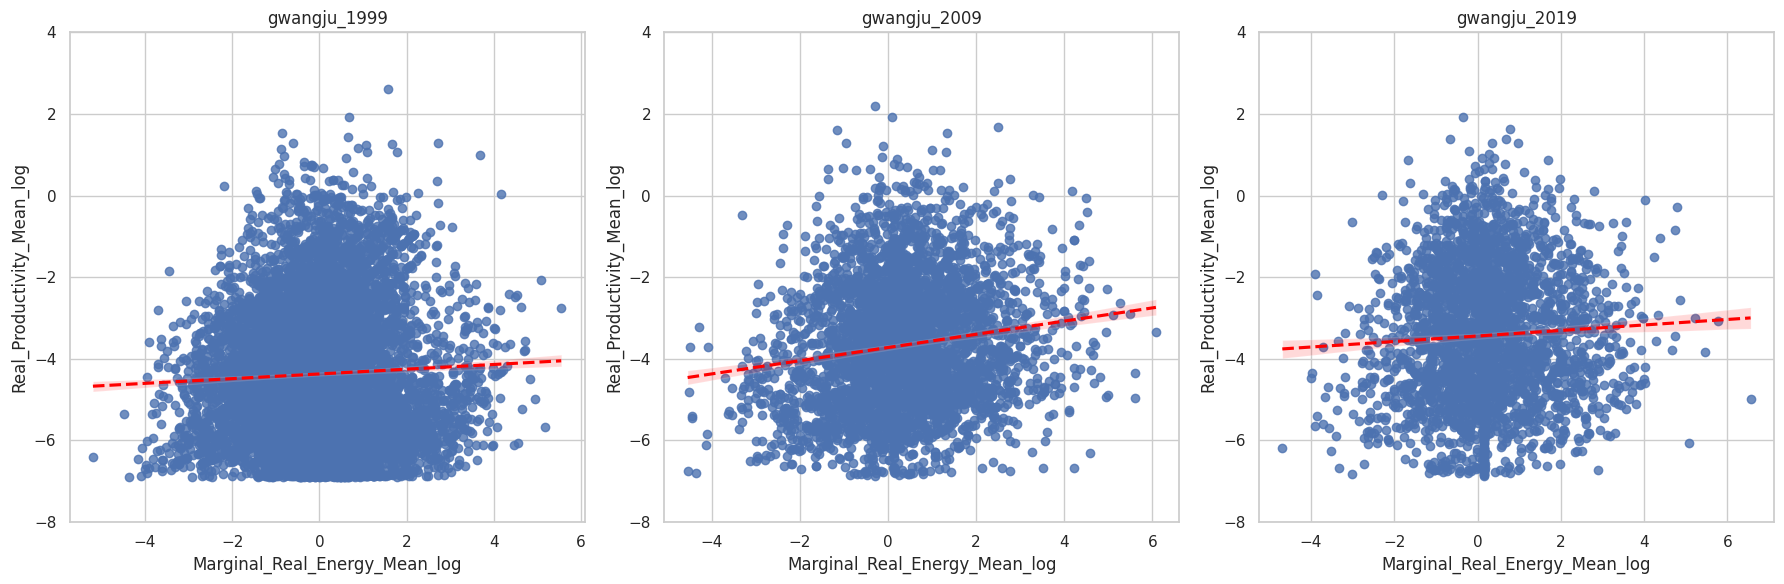

In [ ]:
# 1행 3열의 서브플롯을 생성
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, year in enumerate(years):
    city_data_year = city_data_busan[city_data_busan['year'] == year]
    plot_scatter_and_regression(year, city_data_year, var, ax=axes[i])

plt.tight_layout()
plt.show()

- 행정구역 : 대전

In [ ]:
# 행정지역 필터링
city = '대전'
city_name = 'daejeon'
city_data_daejeon = city_data[city_data['c_city'] == city]

In [ ]:
# # 연도별로 회귀분석 실행
# for year in years:
#     city_data_year = city_data_daejeon[city_data_daejeon['year'] == year]
#     perform_regression(year, city_data_year)

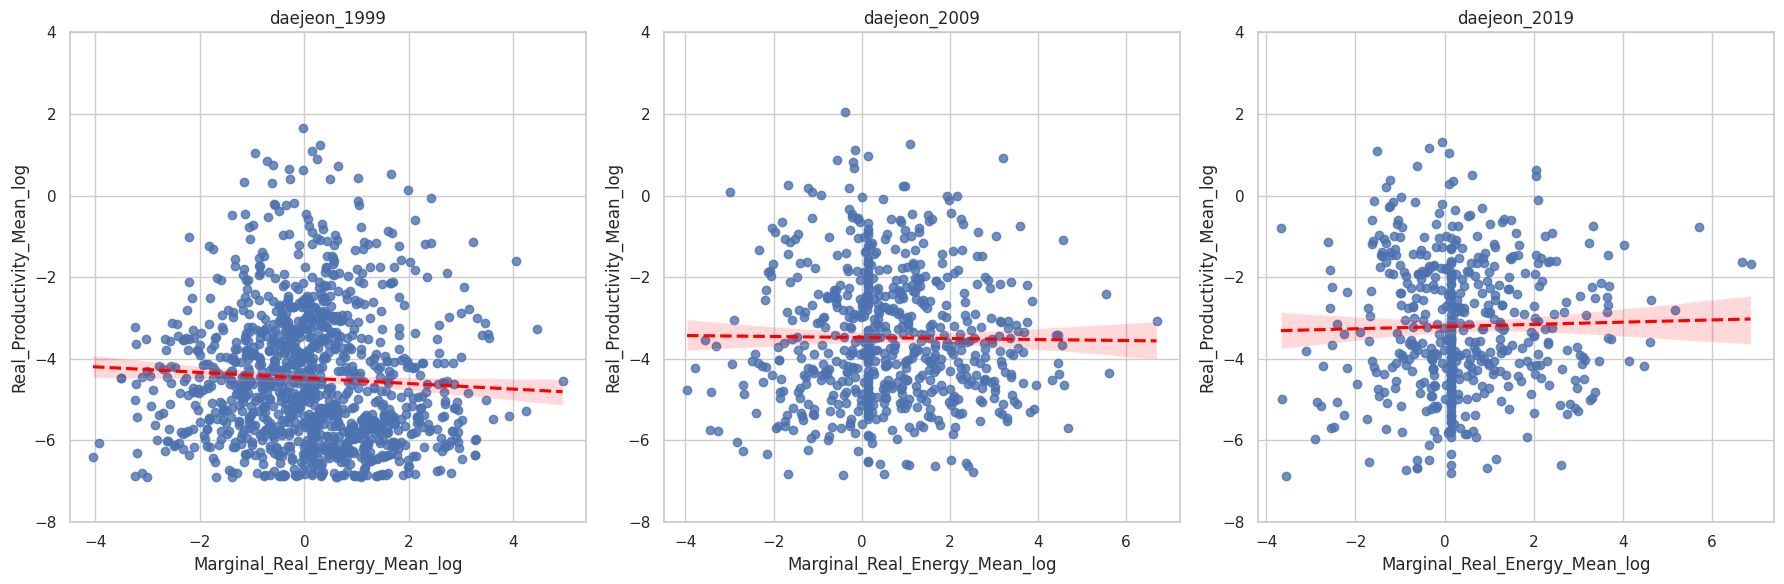

In [ ]:
# 1행 3열의 서브플롯을 생성
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, year in enumerate(years):
    city_data_year = city_data_daejeon[city_data_daejeon['year'] == year]
    plot_scatter_and_regression(year, city_data_year, var, ax=axes[i])

plt.tight_layout()
plt.show()

- 행정구역 : 대구

In [ ]:
# 행정지역 필터링
city = '대구'
city_name = 'daegu'
city_data_daegu = city_data[city_data['c_city'] == city]

In [ ]:

# # 연도별로 회귀분석 실행
# for year in years:
#     city_data_year = city_data_daegu[city_data_daegu['year'] == year]
#     perform_regression(year, city_data_year)

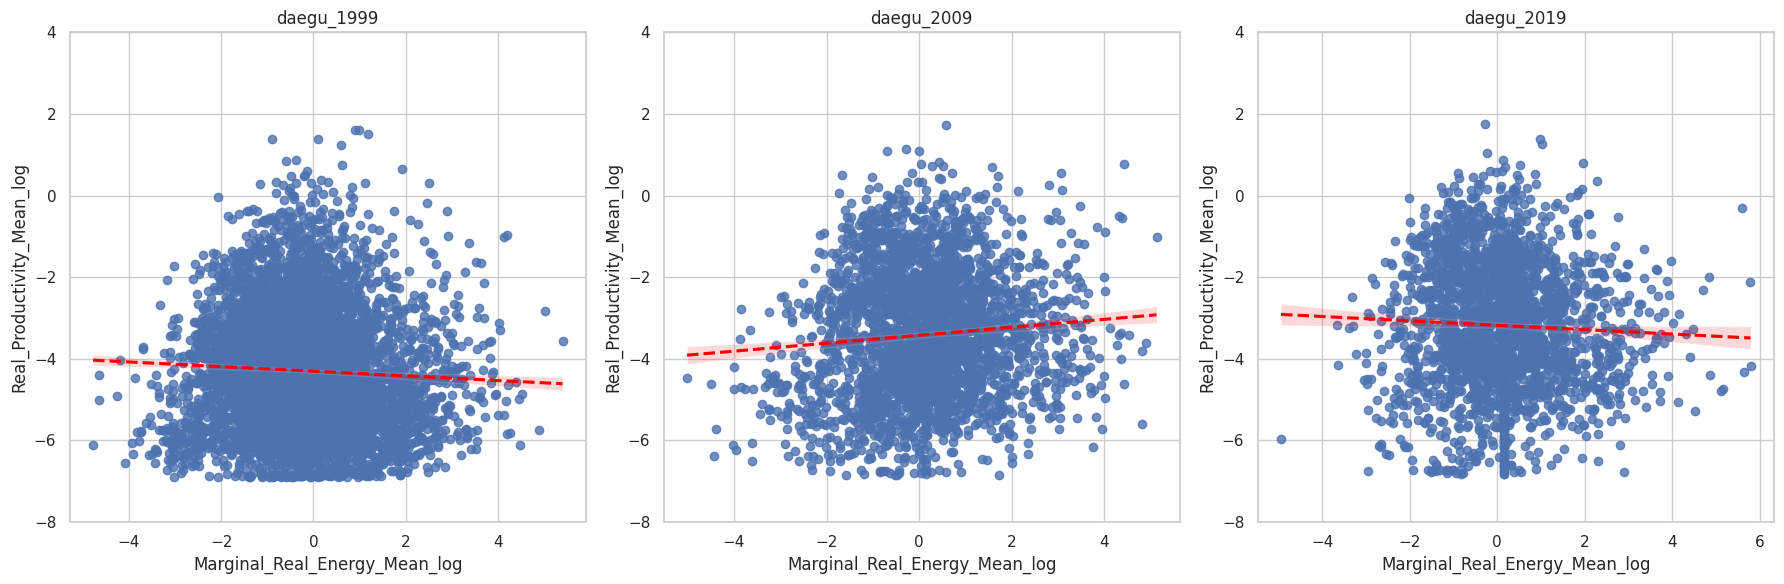

In [ ]:
# 1행 3열의 서브플롯을 생성
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, year in enumerate(years):
    city_data_year = city_data_daegu[city_data_daegu['year'] == year]
    plot_scatter_and_regression(year, city_data_year, var, ax=axes[i])

plt.tight_layout()
plt.show()

- 행정구역 : 인천

In [ ]:
# 행정지역 필터링
city = '인천'
city_name = 'incheon'
city_data_incheon= city_data[city_data['c_city'] == city]

In [ ]:
# # 연도별로 회귀분석 실행
# for year in years:
#     city_data_year = city_data_incheon[city_data_incheon['year'] == year]
#     perform_regression(year, city_data_year)

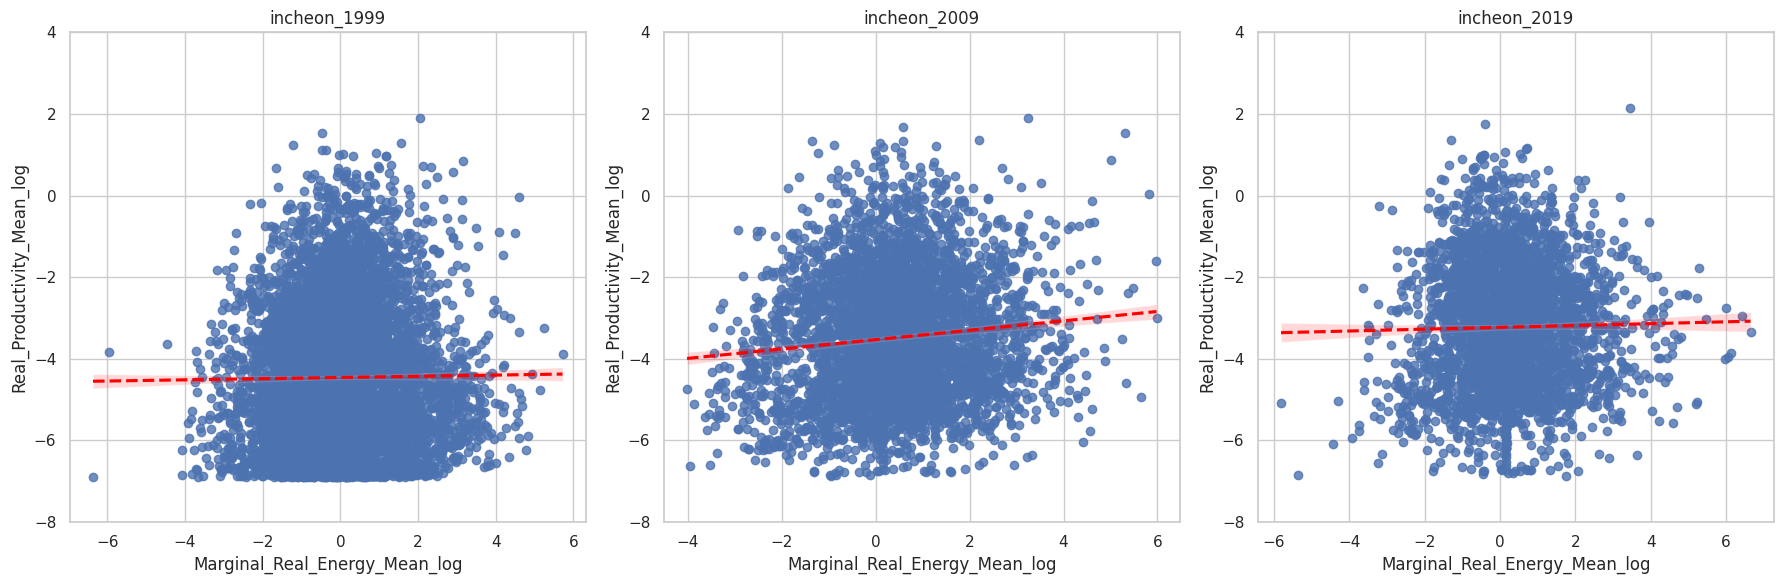

In [ ]:
# 1행 3열의 서브플롯을 생성
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, year in enumerate(years):
    city_data_year = city_data_incheon[city_data_incheon['year'] == year]
    plot_scatter_and_regression(year, city_data_year, var, ax=axes[i])

plt.tight_layout()
plt.show()

- 행정구역 : 울산

In [ ]:
# 행정지역 필터링
city = '울산'
city_name = 'ulsan'
city_data_ulsan= city_data[city_data['c_city'] == city]

In [ ]:
# # 연도별로 회귀분석 실행
# for year in years:
#     city_data_year = city_data_ulsan[city_data_ulsan['year'] == year]
#     perform_regression(year, city_data_year)

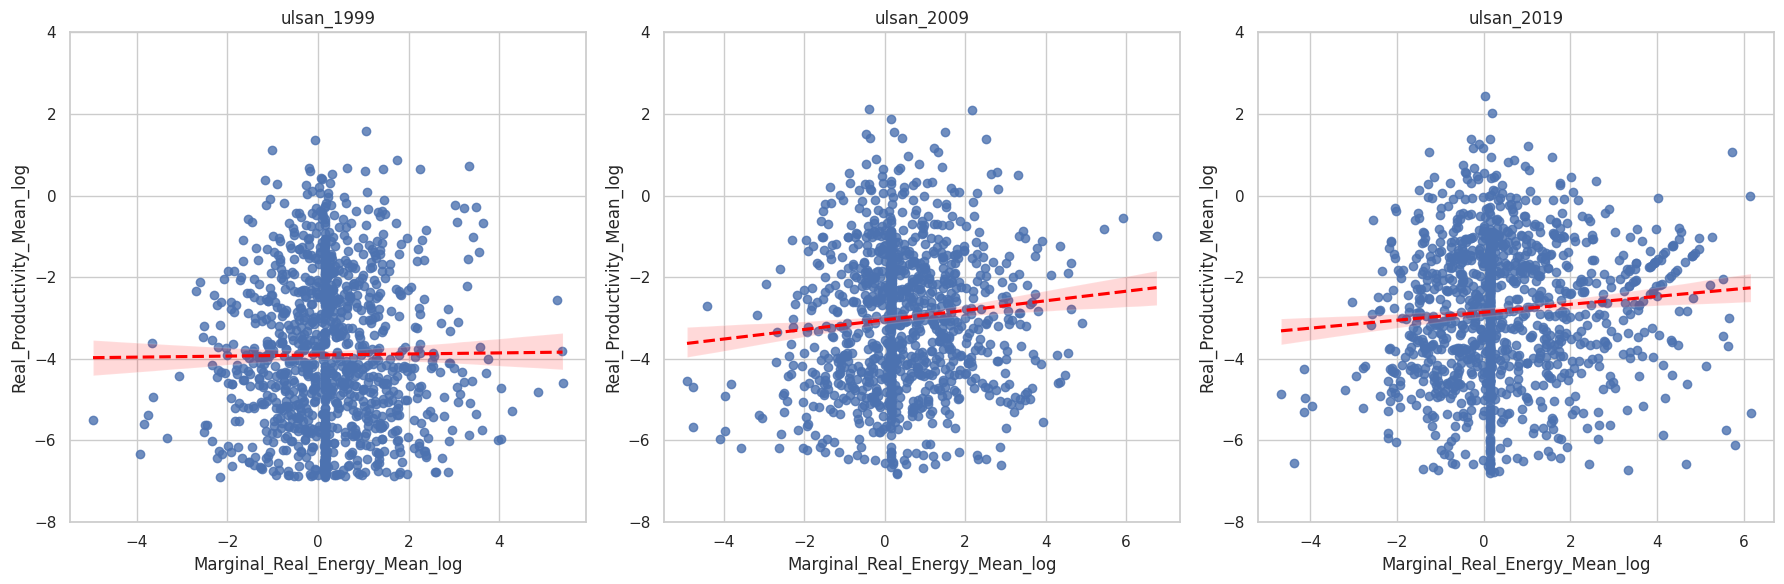

In [ ]:
# 1행 3열의 서브플롯을 생성
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, year in enumerate(years):
    city_data_year = city_data_ulsan[city_data_ulsan['year'] == year]
    plot_scatter_and_regression(year, city_data_year, var, ax=axes[i])

plt.tight_layout()
plt.show()

## 4-1.실질부가가치 성장률과 온실가스 배출량 성장률


실질 부가가치 성장률 도출 방법

* 기업의 실질부가가치 = 기업의 부가가치 / 제조업 대표 물가지수(119.84)
* 기업의 실질부가가치 변화율
* 연도별 기업의 실질 부가가치 변화율의 중앙값
* 지역 순서 : 서울,부산,광주,대전,대구,인천,울산

In [ ]:
def made_real_vadd_growth(df):
    manu_price_index = 119.84
    df['real_vadd_growth'] = df['vadd'] / manu_price_index
    df['real_vadd_growth'] = df['real_vadd_growth'].pct_change() * 100
    real_price_growth = pd.DataFrame(df.groupby('year')['real_vadd_growth'].median())
    return real_price_growth

def real_vadd_growth_gas_graph(city_df, gas_df, city_name):
    vadd_df = made_real_vadd_growth(city_df).reset_index().rename(columns={'year': 'YEAR'})
    gas_df['MADE_pct'] = gas_df['MADE'].pct_change() * 100
    tmp = gas_df[9:][['YEAR', 'MADE_pct']].reset_index(drop=True)
    merge_df = pd.merge(tmp, vadd_df, on='YEAR')

    # graph size
    plt.figure(figsize=(10, 5))

    # first y-axis(manufacture gas emission)
    ax1 = plt.gca()
    ax1.plot(merge_df['YEAR'], merge_df['MADE_pct'], label='Gas_Emission', color='blue')
    ax1.set_ylabel('Gas_Emission(%)')
    ax1.tick_params(axis='y')

    # second y-axis(real_add_growth)
    ax2 = ax1.twinx()
    ax2.plot(merge_df['YEAR'], merge_df['real_vadd_growth'], label='Real_Vadd_Growth', color='green')
    ax2.set_ylabel('Real_Vadd_Growth')
    ax2.tick_params(axis='y')

    # Calculate the correlation coefficient
    corr, _ = pearsonr(merge_df['MADE_pct'], merge_df['real_vadd_growth'])

    # x-axis (year)
    plt.xlabel('YEAR')
    plt.text(2019, 8, f'corr : {corr:.3f}', fontsize=12, ha='right', va='top',color='red')

    # set legend
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(0.05, 0.95))

    plt.title(f'{city_name}_Gas Emission & Real Vadd Growth')
    plt.ylim(-10, 10)
    plt.grid(True)
    ax1.grid(which='both', axis='both')
    ax2.grid(which='both', axis='both')

    plt.show()

<ipython-input-208-724298ce94ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['real_vadd_growth'] = df['vadd'] / manu_price_index
<ipython-input-208-724298ce94ad>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['real_vadd_growth'] = df['real_vadd_growth'].pct_change() * 100


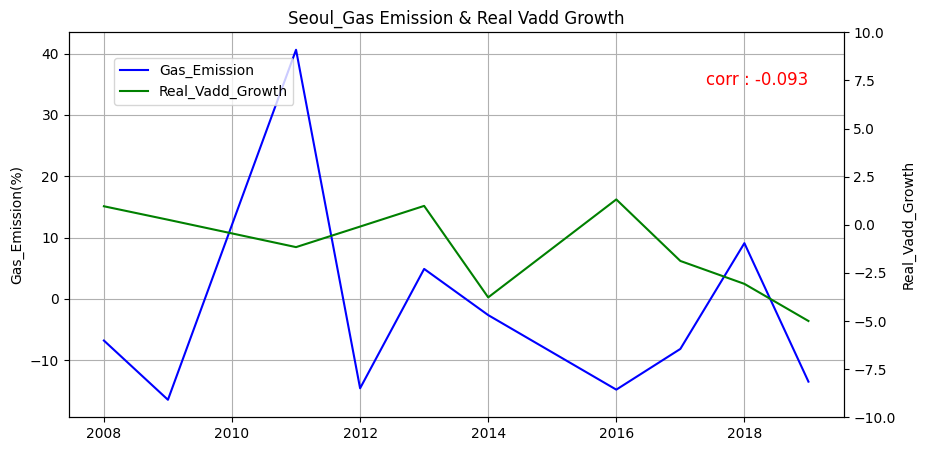

In [ ]:
# 서울
city_name = 'Seoul'
real_vadd_growth_gas_graph(city_data_seoul,seoul_gas,city_name)

<ipython-input-208-724298ce94ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['real_vadd_growth'] = df['vadd'] / manu_price_index
<ipython-input-208-724298ce94ad>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['real_vadd_growth'] = df['real_vadd_growth'].pct_change() * 100


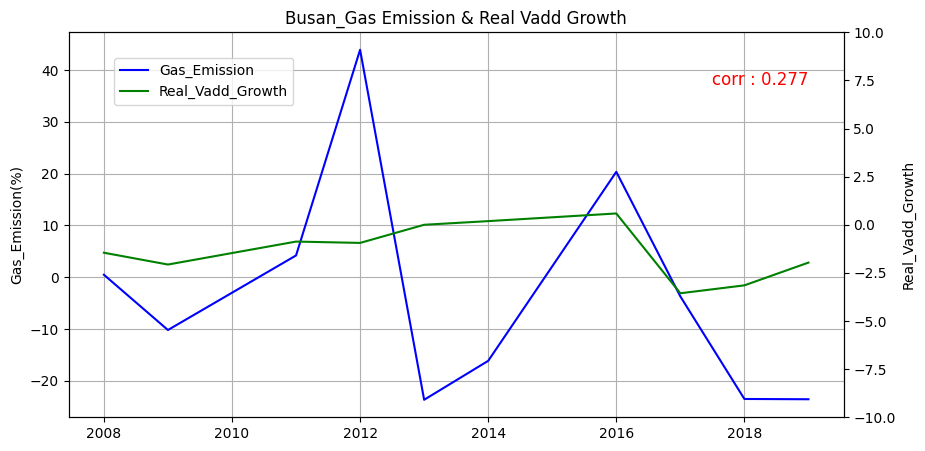

In [ ]:
# 부산
city_name = 'Busan'
real_vadd_growth_gas_graph(city_data_busan,busan_gas,city_name)

<ipython-input-208-724298ce94ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['real_vadd_growth'] = df['vadd'] / manu_price_index
<ipython-input-208-724298ce94ad>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['real_vadd_growth'] = df['real_vadd_growth'].pct_change() * 100


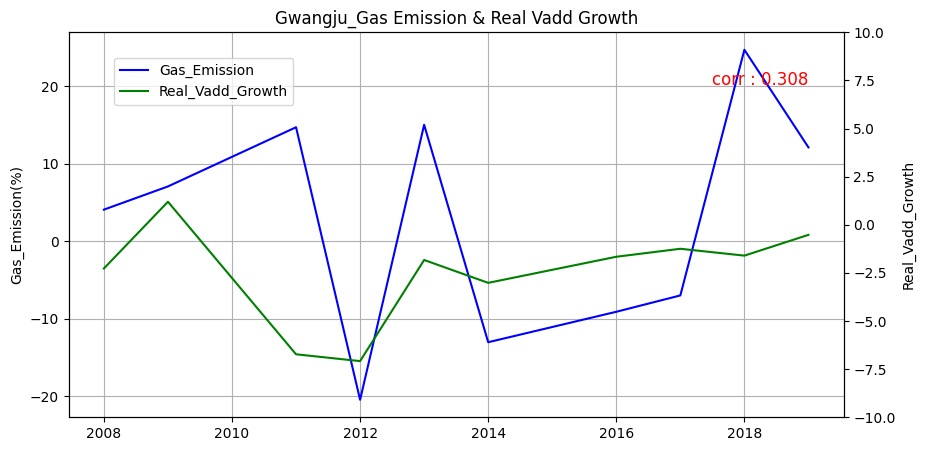

In [ ]:
# 광주
city_name = 'Gwangju'
real_vadd_growth_gas_graph(city_data_gwangju,gwangju_gas,city_name)

<ipython-input-208-724298ce94ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['real_vadd_growth'] = df['vadd'] / manu_price_index
<ipython-input-208-724298ce94ad>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['real_vadd_growth'] = df['real_vadd_growth'].pct_change() * 100


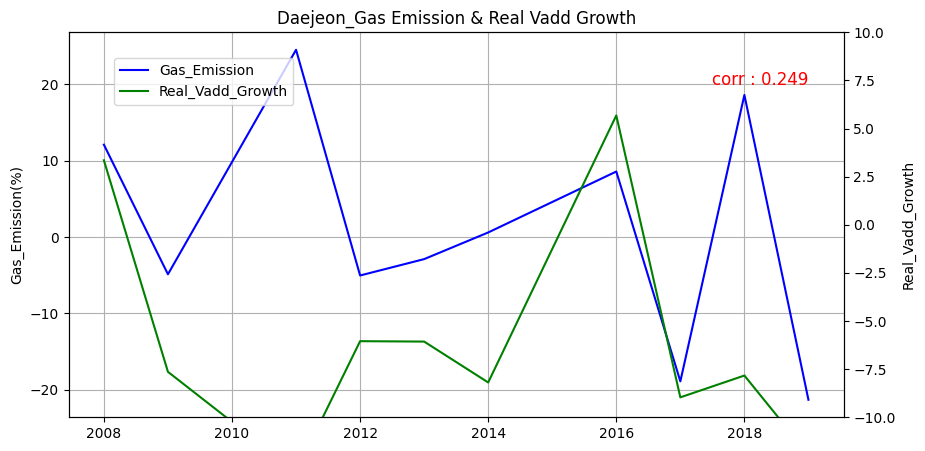

In [ ]:
# 대전
city_name = 'Daejeon'
real_vadd_growth_gas_graph(city_data_daejeon,daejeon_gas,city_name)

<ipython-input-208-724298ce94ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['real_vadd_growth'] = df['vadd'] / manu_price_index
<ipython-input-208-724298ce94ad>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['real_vadd_growth'] = df['real_vadd_growth'].pct_change() * 100


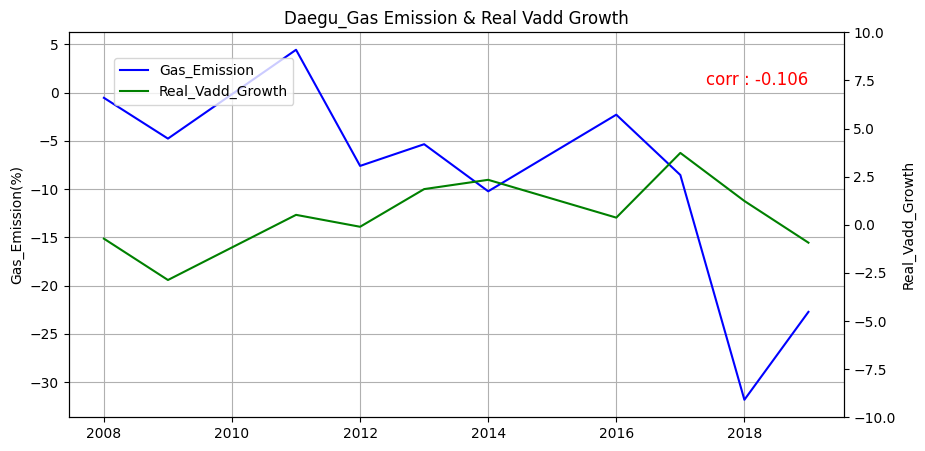

In [ ]:
# 대구
city_name = 'Daegu'
real_vadd_growth_gas_graph(city_data_daegu,daegu_gas,city_name)

<ipython-input-208-724298ce94ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['real_vadd_growth'] = df['vadd'] / manu_price_index
<ipython-input-208-724298ce94ad>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['real_vadd_growth'] = df['real_vadd_growth'].pct_change() * 100


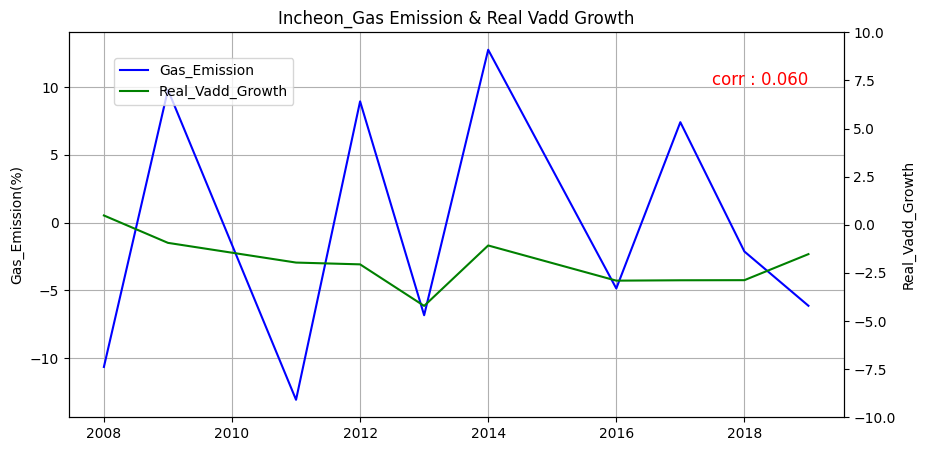

In [ ]:
# 인천
city_name = 'Incheon'
real_vadd_growth_gas_graph(city_data_incheon,incheon_gas,city_name)

<ipython-input-208-724298ce94ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['real_vadd_growth'] = df['vadd'] / manu_price_index
<ipython-input-208-724298ce94ad>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['real_vadd_growth'] = df['real_vadd_growth'].pct_change() * 100


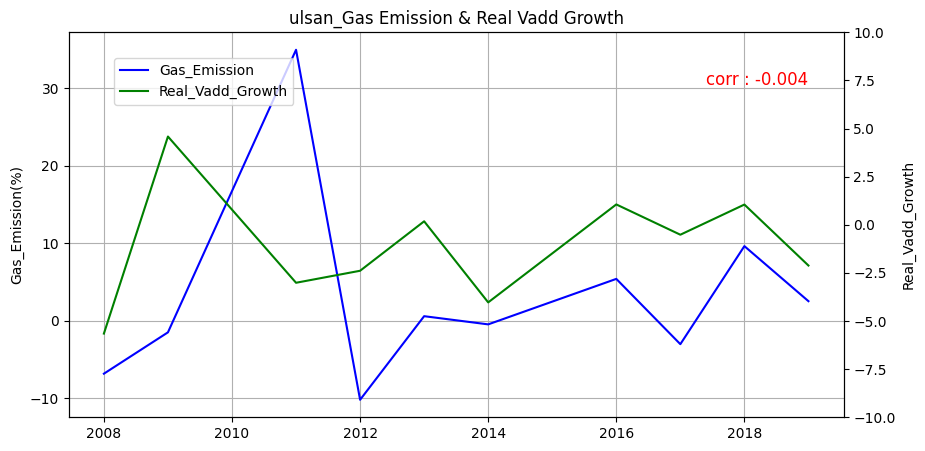

In [ ]:
# 울산
city_name = 'ulsan'
real_vadd_growth_gas_graph(city_data_ulsan,ulsan_gas,city_name)